In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd '/content/drive/My Drive/Colab Notebooks'

/content/drive/My Drive/Colab Notebooks


In [3]:
!pip install torch==1.5.0  torchvision==0.6.0 -f https://download.pytorch.org/whl/torch_stable.html



Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 603.7MB 31kB/s 
     |████████████████████████████████| 6.5MB 48.0MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
!pip install facenet-pytorch

     |████████████████████████████████| 1.9MB 2.5MB/s 


In [5]:
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.nn.init import *
from torchvision import transforms, utils, datasets, models
# from models.inception_resnet_v1 import InceptionResnetV1
from facenet_pytorch import MTCNN, InceptionResnetV1
import cv2
from PIL import Image
from pdb import set_trace
import time
import copy
from pathlib import Path
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage import io, transform
from tqdm import trange, tqdm
import csv
import glob
import dlib
import pandas as pd
import numpy as np

In [7]:
print(torch. __version__)
print(torchvision. __version__)

1.5.0+cu92
0.6.0+cu92


In [8]:
import os
pth='/content/drive/My Drive/Colab Notebooks/EVA_P2/S4/Face_Data'

files=0
folders=0
for _, dirnames, filenames in os.walk(pth):
  files += len(filenames)
  folders += len(dirnames)

print ("{:,} files, {:,} folders".format(files, folders))

6,713 files, 620 folders


In [ ]:
pth1='/content/drive/My Drive/Colab Notebooks/EVA_P2/S4_/data'
pths='/content/drive/My Drive/Colab Notebooks/EVA_P2/S4/Face_Data/'
count=0
mtcnn = MTCNN(post_process=False)
for p,d,f in os.walk(pth1):
  # print(d)
  for d1 in d:
    # print(d1)
    for p2,d2,f2 in os.walk(p+'/'+d1+'/'):
      # print(p2)
      if len(f2)>3:
        count = count+1
        # print(len(f2))
        if not os.path.exists(pths+d1+'/'):
             os.makedirs(pths+d1+'/')
            #  os.makedirs('/content/ZData/Val/'+d1+'/')
        count1 = 0
        for fx in f2:
          count1=count1+1
          im = cv2.imread(p2+fx)
          if im is not None:
            face = mtcnn(im)
            if face is not None:
              cv2.imwrite(pths+d1+'/'+fx, face.permute(1, 2, 0).int().numpy())
              # print('-----',pths+d1+'/'+fx)
            else:
              !rm -rf pths+d1
          else:
            !rm -rf pths+d1

**Downloading datasets and applying transforms**

In [9]:
dataset= datasets.ImageFolder(root="/content/drive/My Drive/Colab Notebooks/EVA_P2/S4/Face_Data")



In [10]:
dataset

Dataset ImageFolder
    Number of datapoints: 6713
    Root location: /content/drive/My Drive/Colab Notebooks/EVA_P2/S4/Face_Data

In [11]:
dataset.class_to_idx

{'Aaron_Peirsol': 0,
 'Abdoulaye_Wade': 1,
 'Abdullah': 2,
 'Abdullah_Gul': 3,
 'Abel_Pacheco': 4,
 'Adam_Sandler': 5,
 'Adrien_Brody': 6,
 'Ahmed_Chalabi': 7,
 'Ai_Sugiyama': 8,
 'Al_Gore': 9,
 'Al_Sharpton': 10,
 'Alan_Greenspan': 11,
 'Alastair_Campbell': 12,
 'Albert_Costa': 13,
 'Alec_Baldwin': 14,
 'Alejandro_Toledo': 15,
 'Aleksander_Kwasniewski': 16,
 'Alexander_Downer': 17,
 'Alexander_Losyukov': 18,
 'Ali_Naimi': 19,
 'Allyson_Felix': 20,
 'Alvaro_Silva_Calderon': 21,
 'Alvaro_Uribe': 22,
 'Amanda_Bynes': 23,
 'Amelia_Vega': 24,
 'Amelie_Mauresmo': 25,
 'Amer_al-Saadi': 26,
 'Ana_Guevara': 27,
 'Ana_Palacio': 28,
 'Anders_Fogh_Rasmussen': 29,
 'Andre_Agassi': 30,
 'Andy_Roddick': 31,
 'Angela_Bassett': 32,
 'Angela_Merkel': 33,
 'Angelina_Jolie': 34,
 'Angelo_Reyes': 35,
 'Ann_Veneman': 36,
 'Anna_Kournikova': 37,
 'Antonio_Banderas': 38,
 'Antonio_Palocci': 39,
 'Antony_Leung': 40,
 'Ari_Fleischer': 41,
 'Arianna_Huffington': 42,
 'Ariel_Sharon': 43,
 'Arminio_Fraga': 44,
 '

In [13]:
classes=[]
classes=dataset.classes

In [12]:
train_set, test_set = torch.utils.data.random_split(dataset, [5000, 1713])

In [15]:
transform_train = transforms.Compose(
[
 transforms.Resize(160),
        # transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
[
 transforms.Resize(160),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [16]:
class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map :     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)


        # if self.map:     
        #       x = self.map(self.dataset[index][0]) 
        #   else:     
        #       x = self.dataset[index][0]  # image
        #   y = self.dataset[index][1]   # label   

In [17]:
trainset = MapDataset(train_set, transform_train)

testset = MapDataset(test_set, transform_test)

**Loading data to train and test loader**

In [18]:
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
# For reproducibility
torch.manual_seed(111)

if cuda:
    torch.cuda.manual_seed(111)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True,num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=True, num_workers=4)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

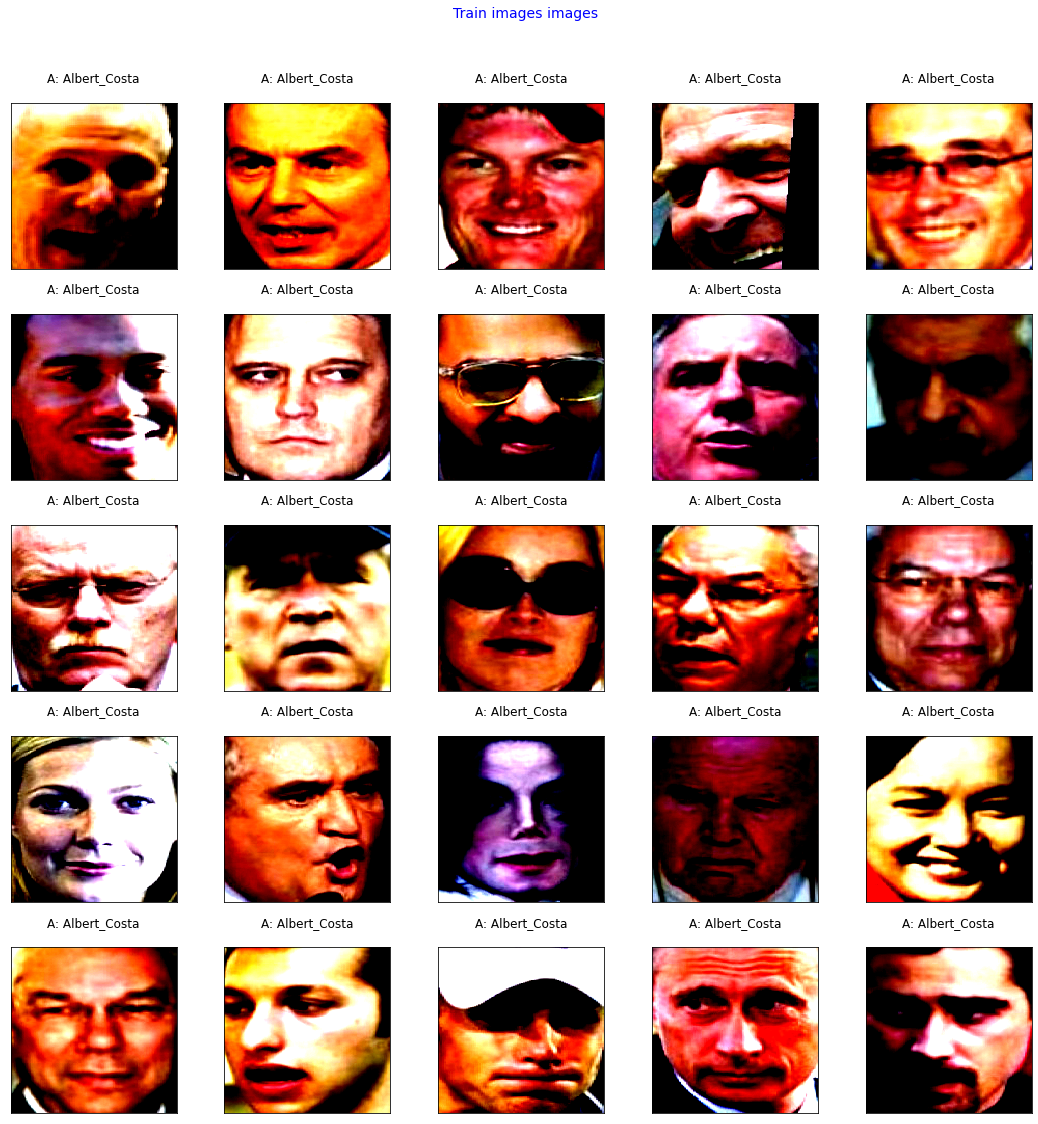

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import PIL.Image as Image

# classes = ('FB', 'LQ', 'SQ','WD')


fig = plt.figure()
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Train images images' ,y=1.05,fontsize=14,color='b')

dataiter = iter(trainloader)
images, labels = dataiter.next()


for i in range(25):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(((images[i]).permute(1,2,0).numpy().squeeze()), interpolation='none')
  plt.title('A: {}\n'.format(classes[labels[126]]))

  plt.xticks([])
  plt.yticks([])


**Building model network**

**Adding model to device**

In [19]:
Net = InceptionResnetV1(pretrained='vggface2', classify=False)


In [20]:
list(Net.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [21]:
layer_list = list(Net.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [22]:
Net = nn.Sequential(*list(Net.children())[:-5])

In [23]:
for param in Net.parameters():
    param.requires_grad = False

In [24]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

In [25]:
Net.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
Net.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
Net.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
Net.logits = nn.Linear(layer_list[4].in_features, 620)
# Net.softmax = nn.Softmax(dim=1)
# Net = Net.to(device)

In [26]:
for i, param in enumerate(Net.parameters()):
    # param.requires_grad = False
    print(i, param.requires_grad)



0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False


In [27]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net.to(device)
summary(model,input_size=(3,160,160))
print("Model added to device")

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 79, 79]             864
       BatchNorm2d-2           [-1, 32, 79, 79]              64
              ReLU-3           [-1, 32, 79, 79]               0
       BasicConv2d-4           [-1, 32, 79, 79]               0
            Conv2d-5           [-1, 32, 77, 77]           9,216
       BatchNorm2d-6           [-1, 32, 77, 77]              64
              ReLU-7           [-1, 32, 77, 77]               0
       BasicConv2d-8           [-1, 32, 77, 77]               0
            Conv2d-9           [-1, 64, 77, 77]          18,432
      BatchNorm2d-10           [-1, 64, 77, 77]             128
             ReLU-11           [-1, 64, 77, 77]               0
      BasicConv2d-12           [-1, 64, 77, 77]               0
        MaxPool2d-13           [-1, 64, 38, 38]               0
           Conv2d-14           [-1

**LR Finder**

In [28]:

def training_model_with_scheduler(model, device, train_loader, optimizer,scheduler,criterion):

  import torch
  import torch.nn as nn
  import torch.nn.functional as F
  import torch.optim as optim
  from torchvision import datasets, transforms
  import torchvision
  from torchsummary import summary
  from tqdm import tqdm

  model.train()
  pbar=tqdm(train_loader)
  train_losses=[]
  train_acces=[]

  correct = 0
  processed = 0
  train_loss=0
  running_loss=0
  lr_step=0
  ep=len(train_loader)

  L2lambda=0
  for data,target in train_loader:
    data, target = data.to(device), target.to(device)
    
    
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = criterion(y_pred, target)
    
    running_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    scheduler.step()
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    acc=100*(correct/processed)

    

  running_loss /=len(data)
  train_losses.append(running_loss)
  train_acces.append(acc)
  
  # scheduler.step(running_loss)
  print("LR used in this epoch is:",lr_step)
  print('\nTrain set: Average loss: {:.4f}, Train Accuracy: ({:.2f}%)\n'.format(running_loss,acc))  
  return train_losses,train_acces


In [29]:


def testing_model(model, device, testloader):
    model.eval()
    test_loss = 0
    correct = 0
    test_losses=[]
    test_acces=[]
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
      for datax in testloader:
          data ,target =datax
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += criterion(output, target).item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /=len(data)
    test_losses.append(test_loss)
    test_acc=(100. * correct / len(testloader.dataset))
    test_acces.append(test_acc)
    print('\nTest set: Average Loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),test_acc))
    return test_losses,test_acces

**Defining optimizer and Training model**

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR


train_los=[]
train_acs=[]
test_los=[]
test_acs=[]
lr_data=[]

L2lambda=0
ep=len(trainloader)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,nesterov=True, weight_decay=L2lambda)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1.5, epochs=100,steps_per_epoch=ep,pct_start=0.2)

EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    
    train_losses,train_acces=training_model_with_scheduler(model, device, trainloader, optimizer,scheduler,criterion)
    train_los.append(train_losses)
    train_acs.append(train_acces)
    test_losses, test_acces=testing_model(model, device, testloader)
    test_los.append(test_losses)
    test_acs.append(test_acces)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1
LR used in this epoch is: 0.06725521665559886

Train set: Average loss: 0.1630, Train Accuracy: (8.78%)




  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1430, Test Accuracy: 179/1713 (10.45%)

EPOCH: 2
LR used in this epoch is: 0.09214731490905992

Train set: Average loss: 0.1590, Train Accuracy: (12.18%)





  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1391, Test Accuracy: 172/1713 (10.04%)

EPOCH: 3
LR used in this epoch is: 0.1341469255290264

Train set: Average loss: 0.1528, Train Accuracy: (11.80%)






  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1331, Test Accuracy: 171/1713 (9.98%)

EPOCH: 4
LR used in this epoch is: 0.19220948058163256

Train set: Average loss: 0.1452, Train Accuracy: (11.64%)







  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1294, Test Accuracy: 172/1713 (10.04%)

EPOCH: 5
LR used in this epoch is: 0.26489091231789286

Train set: Average loss: 0.1399, Train Accuracy: (11.78%)








  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1240, Test Accuracy: 172/1713 (10.04%)

EPOCH: 6
LR used in this epoch is: 0.3503835684320238

Train set: Average loss: 0.1345, Train Accuracy: (13.10%)









  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1200, Test Accuracy: 256/1713 (14.94%)

EPOCH: 7
LR used in this epoch is: 0.4465611699933496

Train set: Average loss: 0.1298, Train Accuracy: (17.40%)










  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1159, Test Accuracy: 308/1713 (17.98%)

EPOCH: 8
LR used in this epoch is: 0.5510316939077485

Train set: Average loss: 0.1252, Train Accuracy: (19.96%)











  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1112, Test Accuracy: 348/1713 (20.32%)

EPOCH: 9
LR used in this epoch is: 0.6611968646744645

Train set: Average loss: 0.1213, Train Accuracy: (23.10%)












  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1098, Test Accuracy: 428/1713 (24.99%)

EPOCH: 10
LR used in this epoch is: 0.7743167758250064

Train set: Average loss: 0.1174, Train Accuracy: (28.36%)













  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1045, Test Accuracy: 485/1713 (28.31%)

EPOCH: 11
LR used in this epoch is: 0.8875780338510679

Train set: Average loss: 0.1138, Train Accuracy: (31.10%)














  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1016, Test Accuracy: 510/1713 (29.77%)

EPOCH: 12
LR used in this epoch is: 0.9981637298209485

Train set: Average loss: 0.1105, Train Accuracy: (33.20%)















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.1006, Test Accuracy: 544/1713 (31.76%)

EPOCH: 13
LR used in this epoch is: 1.1033234984277025

Train set: Average loss: 0.1071, Train Accuracy: (35.32%)
















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0984, Test Accuracy: 577/1713 (33.68%)

EPOCH: 14
LR used in this epoch is: 1.2004419220377405

Train set: Average loss: 0.1040, Train Accuracy: (36.92%)

















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0958, Test Accuracy: 596/1713 (34.79%)

EPOCH: 15
LR used in this epoch is: 1.287103578469924

Train set: Average loss: 0.1010, Train Accuracy: (38.36%)


















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0931, Test Accuracy: 626/1713 (36.54%)

EPOCH: 16
LR used in this epoch is: 1.3611531147086293

Train set: Average loss: 0.0982, Train Accuracy: (40.36%)



















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0913, Test Accuracy: 653/1713 (38.12%)

EPOCH: 17
LR used in this epoch is: 1.4207488524637297

Train set: Average loss: 0.0954, Train Accuracy: (42.26%)




















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0897, Test Accuracy: 686/1713 (40.05%)

EPOCH: 18
LR used in this epoch is: 1.4644085923592036

Train set: Average loss: 0.0928, Train Accuracy: (44.08%)





















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0874, Test Accuracy: 704/1713 (41.10%)

EPOCH: 19
LR used in this epoch is: 1.4910464775591772

Train set: Average loss: 0.0902, Train Accuracy: (45.64%)






















  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0858, Test Accuracy: 727/1713 (42.44%)

EPOCH: 20
LR used in this epoch is: 1.5

Train set: Average loss: 0.0878, Train Accuracy: (46.98%)























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0843, Test Accuracy: 740/1713 (43.20%)

EPOCH: 21
LR used in this epoch is: 1.4994217794934335

Train set: Average loss: 0.0855, Train Accuracy: (48.24%)
























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0823, Test Accuracy: 760/1713 (44.37%)

EPOCH: 22
LR used in this epoch is: 1.4976880095478449

Train set: Average loss: 0.0834, Train Accuracy: (49.46%)

























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0797, Test Accuracy: 782/1713 (45.65%)

EPOCH: 23
LR used in this epoch is: 1.494801363510824

Train set: Average loss: 0.0814, Train Accuracy: (50.74%)


























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0795, Test Accuracy: 803/1713 (46.88%)

EPOCH: 24
LR used in this epoch is: 1.4907662923813316

Train set: Average loss: 0.0793, Train Accuracy: (51.74%)



























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0782, Test Accuracy: 815/1713 (47.58%)

EPOCH: 25
LR used in this epoch is: 1.4855890179465816

Train set: Average loss: 0.0774, Train Accuracy: (53.14%)




























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0760, Test Accuracy: 827/1713 (48.28%)

EPOCH: 26
LR used in this epoch is: 1.4792775231884963

Train set: Average loss: 0.0756, Train Accuracy: (53.98%)





























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0753, Test Accuracy: 844/1713 (49.27%)

EPOCH: 27
LR used in this epoch is: 1.471841539974526

Train set: Average loss: 0.0738, Train Accuracy: (55.06%)






























  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0741, Test Accuracy: 855/1713 (49.91%)

EPOCH: 28
LR used in this epoch is: 1.4632925340518164

Train set: Average loss: 0.0723, Train Accuracy: (55.76%)































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0717, Test Accuracy: 866/1713 (50.55%)

EPOCH: 29
LR used in this epoch is: 1.4536436873678555

Train set: Average loss: 0.0705, Train Accuracy: (56.84%)
































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0717, Test Accuracy: 880/1713 (51.37%)

EPOCH: 30
LR used in this epoch is: 1.4429098777448675

Train set: Average loss: 0.0690, Train Accuracy: (57.90%)

































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0695, Test Accuracy: 891/1713 (52.01%)

EPOCH: 31
LR used in this epoch is: 1.4311076559392895

Train set: Average loss: 0.0674, Train Accuracy: (58.52%)


































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0710, Test Accuracy: 900/1713 (52.54%)

EPOCH: 32
LR used in this epoch is: 1.4182552201217034

Train set: Average loss: 0.0662, Train Accuracy: (59.60%)



































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0678, Test Accuracy: 914/1713 (53.36%)

EPOCH: 33
LR used in this epoch is: 1.4043723878165766

Train set: Average loss: 0.0648, Train Accuracy: (60.46%)




































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0679, Test Accuracy: 932/1713 (54.41%)

EPOCH: 34
LR used in this epoch is: 1.3894805653450761

Train set: Average loss: 0.0633, Train Accuracy: (61.72%)





































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0665, Test Accuracy: 950/1713 (55.46%)

EPOCH: 35
LR used in this epoch is: 1.373602714818072

Train set: Average loss: 0.0621, Train Accuracy: (62.30%)






































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0653, Test Accuracy: 963/1713 (56.22%)

EPOCH: 36
LR used in this epoch is: 1.3567633187302275

Train set: Average loss: 0.0608, Train Accuracy: (63.32%)







































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0669, Test Accuracy: 970/1713 (56.63%)

EPOCH: 37
LR used in this epoch is: 1.338988342209766

Train set: Average loss: 0.0595, Train Accuracy: (64.34%)








































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0642, Test Accuracy: 983/1713 (57.38%)

EPOCH: 38
LR used in this epoch is: 1.3203051929821266

Train set: Average loss: 0.0585, Train Accuracy: (65.64%)









































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0637, Test Accuracy: 1001/1713 (58.44%)

EPOCH: 39
LR used in this epoch is: 1.3007426791092358

Train set: Average loss: 0.0574, Train Accuracy: (65.82%)










































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0622, Test Accuracy: 1002/1713 (58.49%)

EPOCH: 40
LR used in this epoch is: 1.280330964569567

Train set: Average loss: 0.0562, Train Accuracy: (66.82%)











































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0620, Test Accuracy: 1013/1713 (59.14%)

EPOCH: 41
LR used in this epoch is: 1.2591015227474698

Train set: Average loss: 0.0552, Train Accuracy: (67.42%)












































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0614, Test Accuracy: 1023/1713 (59.72%)

EPOCH: 42
LR used in this epoch is: 1.2370870879034925

Train set: Average loss: 0.0540, Train Accuracy: (68.36%)













































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0603, Test Accuracy: 1029/1713 (60.07%)

EPOCH: 43
LR used in this epoch is: 1.2143216047005276

Train set: Average loss: 0.0530, Train Accuracy: (69.12%)














































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0603, Test Accuracy: 1026/1713 (59.89%)

EPOCH: 44
LR used in this epoch is: 1.190840175863598

Train set: Average loss: 0.0521, Train Accuracy: (69.60%)















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0580, Test Accuracy: 1037/1713 (60.54%)

EPOCH: 45
LR used in this epoch is: 1.1666790080540026

Train set: Average loss: 0.0512, Train Accuracy: (70.14%)
















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0590, Test Accuracy: 1038/1713 (60.60%)

EPOCH: 46
LR used in this epoch is: 1.1418753560412673

Train set: Average loss: 0.0503, Train Accuracy: (70.90%)

















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0592, Test Accuracy: 1053/1713 (61.47%)

EPOCH: 47
LR used in this epoch is: 1.1164674652589919

Train set: Average loss: 0.0494, Train Accuracy: (71.52%)


















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0571, Test Accuracy: 1056/1713 (61.65%)

EPOCH: 48
LR used in this epoch is: 1.090494512833161

Train set: Average loss: 0.0486, Train Accuracy: (71.80%)



















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0571, Test Accuracy: 1061/1713 (61.94%)

EPOCH: 49
LR used in this epoch is: 1.0639965471738584

Train set: Average loss: 0.0477, Train Accuracy: (72.50%)




















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0550, Test Accuracy: 1065/1713 (62.17%)

EPOCH: 50
LR used in this epoch is: 1.0370144262235204

Train set: Average loss: 0.0470, Train Accuracy: (73.02%)





















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0545, Test Accuracy: 1068/1713 (62.35%)

EPOCH: 51
LR used in this epoch is: 1.0095897544569485

Train set: Average loss: 0.0462, Train Accuracy: (73.44%)






















































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0540, Test Accuracy: 1076/1713 (62.81%)

EPOCH: 52
LR used in this epoch is: 0.9817648187302275

Train set: Average loss: 0.0453, Train Accuracy: (73.80%)























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0542, Test Accuracy: 1083/1713 (63.22%)

EPOCH: 53
LR used in this epoch is: 0.9535825230774561

Train set: Average loss: 0.0446, Train Accuracy: (74.42%)
























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0534, Test Accuracy: 1084/1713 (63.28%)

EPOCH: 54
LR used in this epoch is: 0.9250863225558376

Train set: Average loss: 0.0440, Train Accuracy: (75.04%)

























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0532, Test Accuracy: 1099/1713 (64.16%)

EPOCH: 55
LR used in this epoch is: 0.8963201562411303

Train set: Average loss: 0.0432, Train Accuracy: (75.18%)


























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0517, Test Accuracy: 1105/1713 (64.51%)

EPOCH: 56
LR used in this epoch is: 0.8673283794767781

Train set: Average loss: 0.0426, Train Accuracy: (75.84%)



























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0512, Test Accuracy: 1108/1713 (64.68%)

EPOCH: 57
LR used in this epoch is: 0.838155695481186

Train set: Average loss: 0.0419, Train Accuracy: (76.64%)




























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0517, Test Accuracy: 1120/1713 (65.38%)

EPOCH: 58
LR used in this epoch is: 0.8088470864185966

Train set: Average loss: 0.0413, Train Accuracy: (77.12%)





























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0512, Test Accuracy: 1118/1713 (65.27%)

EPOCH: 59
LR used in this epoch is: 0.7794477440398542

Train set: Average loss: 0.0407, Train Accuracy: (77.46%)






























































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0499, Test Accuracy: 1123/1713 (65.56%)

EPOCH: 60
LR used in this epoch is: 0.750003

Train set: Average loss: 0.0401, Train Accuracy: (78.16%)































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0506, Test Accuracy: 1137/1713 (66.37%)

EPOCH: 61
LR used in this epoch is: 0.720558255960146

Train set: Average loss: 0.0395, Train Accuracy: (78.36%)
































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0509, Test Accuracy: 1139/1713 (66.49%)

EPOCH: 62
LR used in this epoch is: 0.6911589135814036

Train set: Average loss: 0.0391, Train Accuracy: (79.34%)

































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0497, Test Accuracy: 1142/1713 (66.67%)

EPOCH: 63
LR used in this epoch is: 0.6618503045188142

Train set: Average loss: 0.0385, Train Accuracy: (79.88%)


































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0504, Test Accuracy: 1153/1713 (67.31%)

EPOCH: 64
LR used in this epoch is: 0.6326776205232217

Train set: Average loss: 0.0379, Train Accuracy: (80.16%)



































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0483, Test Accuracy: 1157/1713 (67.54%)

EPOCH: 65
LR used in this epoch is: 0.6036858437588699

Train set: Average loss: 0.0376, Train Accuracy: (80.74%)




































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0492, Test Accuracy: 1159/1713 (67.66%)

EPOCH: 66
LR used in this epoch is: 0.5749196774441627

Train set: Average loss: 0.0371, Train Accuracy: (81.32%)





































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0491, Test Accuracy: 1167/1713 (68.13%)

EPOCH: 67
LR used in this epoch is: 0.5464234769225439

Train set: Average loss: 0.0366, Train Accuracy: (81.68%)






































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0500, Test Accuracy: 1168/1713 (68.18%)

EPOCH: 68
LR used in this epoch is: 0.5182411812697726

Train set: Average loss: 0.0362, Train Accuracy: (82.22%)







































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0477, Test Accuracy: 1166/1713 (68.07%)

EPOCH: 69
LR used in this epoch is: 0.49041624554305135

Train set: Average loss: 0.0357, Train Accuracy: (82.36%)








































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0474, Test Accuracy: 1173/1713 (68.48%)

EPOCH: 70
LR used in this epoch is: 0.4629915737764798

Train set: Average loss: 0.0352, Train Accuracy: (82.82%)









































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0471, Test Accuracy: 1178/1713 (68.77%)

EPOCH: 71
LR used in this epoch is: 0.4360094528261418

Train set: Average loss: 0.0350, Train Accuracy: (83.38%)










































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0471, Test Accuracy: 1179/1713 (68.83%)

EPOCH: 72
LR used in this epoch is: 0.40951148716683916

Train set: Average loss: 0.0347, Train Accuracy: (83.44%)











































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0466, Test Accuracy: 1184/1713 (69.12%)

EPOCH: 73
LR used in this epoch is: 0.3835385347410085

Train set: Average loss: 0.0343, Train Accuracy: (83.82%)












































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0467, Test Accuracy: 1184/1713 (69.12%)

EPOCH: 74
LR used in this epoch is: 0.35813064395873256

Train set: Average loss: 0.0340, Train Accuracy: (84.00%)













































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0466, Test Accuracy: 1187/1713 (69.29%)

EPOCH: 75
LR used in this epoch is: 0.33332699194599763

Train set: Average loss: 0.0337, Train Accuracy: (84.30%)














































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0463, Test Accuracy: 1190/1713 (69.47%)

EPOCH: 76
LR used in this epoch is: 0.30916582413640215

Train set: Average loss: 0.0333, Train Accuracy: (84.80%)















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0459, Test Accuracy: 1199/1713 (69.99%)

EPOCH: 77
LR used in this epoch is: 0.28568439529947237

Train set: Average loss: 0.0330, Train Accuracy: (84.88%)
















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0453, Test Accuracy: 1201/1713 (70.11%)

EPOCH: 78
LR used in this epoch is: 0.26291891209650736

Train set: Average loss: 0.0328, Train Accuracy: (84.98%)

















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0445, Test Accuracy: 1204/1713 (70.29%)

EPOCH: 79
LR used in this epoch is: 0.24090447725253028

Train set: Average loss: 0.0325, Train Accuracy: (85.10%)


















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0451, Test Accuracy: 1204/1713 (70.29%)

EPOCH: 80
LR used in this epoch is: 0.21967503543043299

Train set: Average loss: 0.0323, Train Accuracy: (85.50%)



















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0448, Test Accuracy: 1205/1713 (70.34%)

EPOCH: 81
LR used in this epoch is: 0.19926332089076432

Train set: Average loss: 0.0321, Train Accuracy: (85.74%)




















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0450, Test Accuracy: 1212/1713 (70.75%)

EPOCH: 82
LR used in this epoch is: 0.1797008070178736

Train set: Average loss: 0.0319, Train Accuracy: (85.74%)





















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0450, Test Accuracy: 1212/1713 (70.75%)

EPOCH: 83
LR used in this epoch is: 0.1610176577902341

Train set: Average loss: 0.0317, Train Accuracy: (86.08%)






















































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0463, Test Accuracy: 1213/1713 (70.81%)

EPOCH: 84
LR used in this epoch is: 0.14324268126977263

Train set: Average loss: 0.0315, Train Accuracy: (86.18%)























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0443, Test Accuracy: 1213/1713 (70.81%)

EPOCH: 85
LR used in this epoch is: 0.12640328518192792

Train set: Average loss: 0.0313, Train Accuracy: (86.36%)
























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0452, Test Accuracy: 1217/1713 (71.04%)

EPOCH: 86
LR used in this epoch is: 0.11052543465492394

Train set: Average loss: 0.0312, Train Accuracy: (86.54%)

























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0438, Test Accuracy: 1217/1713 (71.04%)

EPOCH: 87
LR used in this epoch is: 0.09563361218342335

Train set: Average loss: 0.0310, Train Accuracy: (86.78%)


























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0442, Test Accuracy: 1219/1713 (71.16%)

EPOCH: 88
LR used in this epoch is: 0.08175077987829674

Train set: Average loss: 0.0310, Train Accuracy: (86.56%)



























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0440, Test Accuracy: 1222/1713 (71.34%)

EPOCH: 89
LR used in this epoch is: 0.06889834406071046

Train set: Average loss: 0.0309, Train Accuracy: (86.98%)




























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0432, Test Accuracy: 1218/1713 (71.10%)

EPOCH: 90
LR used in this epoch is: 0.057096122255132484

Train set: Average loss: 0.0308, Train Accuracy: (86.82%)





























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0453, Test Accuracy: 1220/1713 (71.22%)

EPOCH: 91
LR used in this epoch is: 0.04636231263214473

Train set: Average loss: 0.0306, Train Accuracy: (86.72%)






























































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0451, Test Accuracy: 1221/1713 (71.28%)

EPOCH: 92
LR used in this epoch is: 0.03671346594818374

Train set: Average loss: 0.0306, Train Accuracy: (86.90%)































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0446, Test Accuracy: 1223/1713 (71.40%)

EPOCH: 93
LR used in this epoch is: 0.028164460025473986

Train set: Average loss: 0.0306, Train Accuracy: (86.98%)
































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0442, Test Accuracy: 1222/1713 (71.34%)

EPOCH: 94
LR used in this epoch is: 0.020728476811503777

Train set: Average loss: 0.0305, Train Accuracy: (87.22%)

































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0436, Test Accuracy: 1224/1713 (71.45%)

EPOCH: 95
LR used in this epoch is: 0.014416982053418388

Train set: Average loss: 0.0305, Train Accuracy: (87.22%)


































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0440, Test Accuracy: 1223/1713 (71.40%)

EPOCH: 96
LR used in this epoch is: 0.009239707618668542

Train set: Average loss: 0.0305, Train Accuracy: (87.26%)



































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0443, Test Accuracy: 1224/1713 (71.45%)

EPOCH: 97
LR used in this epoch is: 0.005204636489176145

Train set: Average loss: 0.0305, Train Accuracy: (87.06%)




































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0438, Test Accuracy: 1224/1713 (71.45%)

EPOCH: 98
LR used in this epoch is: 0.0023179904521552267

Train set: Average loss: 0.0305, Train Accuracy: (87.26%)





































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0441, Test Accuracy: 1225/1713 (71.51%)

EPOCH: 99
LR used in this epoch is: 0.0005842205065665465

Train set: Average loss: 0.0304, Train Accuracy: (87.08%)






































































































  0%|          | 0/10 [00:00<?, ?it/s]


Test set: Average Loss: 0.0435, Test Accuracy: 1224/1713 (71.45%)

EPOCH: 100
LR used in this epoch is: 6e-06

Train set: Average loss: 0.0305, Train Accuracy: (87.18%)


Test set: Average Loss: 0.0436, Test Accuracy: 1225/1713 (71.51%)



In [37]:
import json
with open('EVA_P2/S4/face_classes.json', 'w') as f:
    json.dump(classes, f)

In [38]:
model.to('cpu')
model.eval()

traced_model =torch.jit.trace(model,torch.randn(1,3,160,160))
torch.jit.save(traced_model,'EVA_P2/S4/face_recognition_cnn1.pt')



**Loss and Accuracy graphs**

In [ ]:
import pandas as pd
tr_lo_df=pd.DataFrame(train_los,columns=['Loss'])
ts_lo_df=pd.DataFrame(test_los,columns=['Loss'])
tr_ac_df=pd.DataFrame(train_acs,columns=['acc'])
ts_ac_df=pd.DataFrame(test_acs,columns=['acc'])

Text(0.5, 1.0, 'Train Test Accuracy')

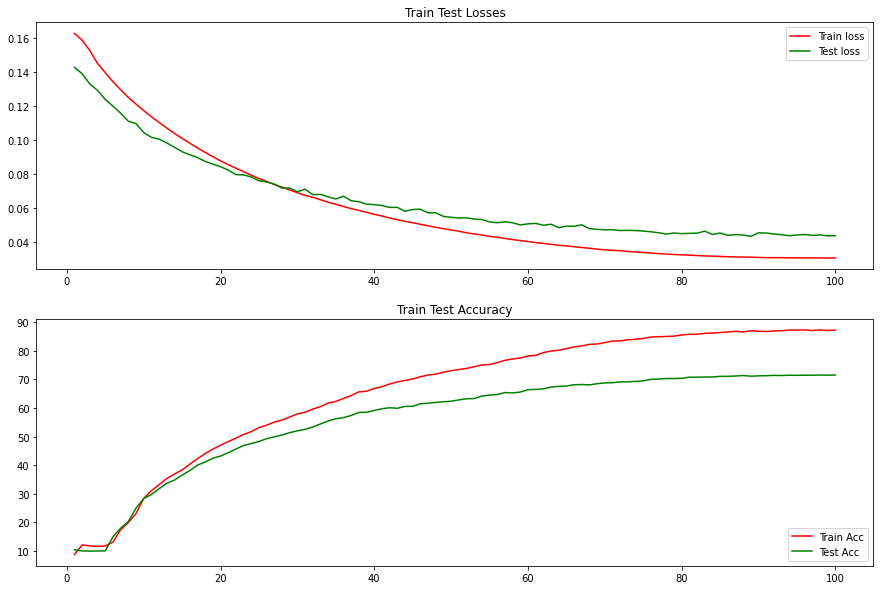

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,1,figsize=(15,10))
axs[0].plot(tr_lo_df.index+1,tr_lo_df['Loss'],color='red')
axs[0].plot(ts_lo_df.index+1,ts_lo_df['Loss'],color='green')

axs[0].legend(['Train loss','Test loss'], loc='upper right')
axs[0].set_title("Train Test Losses")
# axs[0].set_ylim([-100,800])


axs[1].plot(tr_ac_df.index+1,tr_ac_df['acc'],color='red')
axs[1].plot(ts_ac_df.index+1,ts_ac_df['acc'],color='green')

axs[1].legend(['Train Acc','Test Acc'], loc='lower right')
axs[1].set_title("Train Test Accuracy")

**Miss classified Images**

In [ ]:
model.to(device)
incorrect_images,incorrect_images_label,incorrect_images_predl=get_miss_classified_images(model,device,testloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

<Figure size 432x288 with 0 Axes>

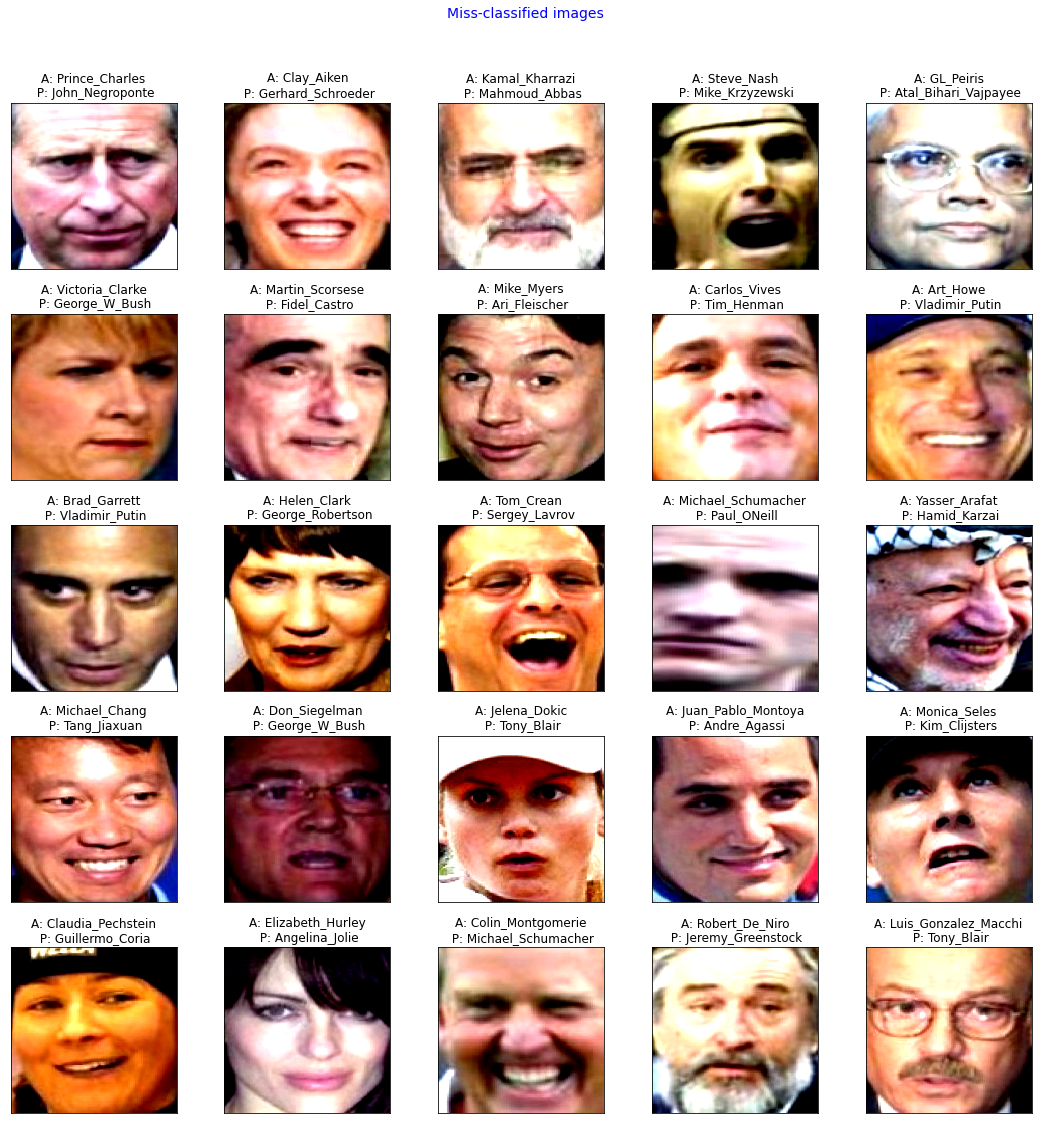

In [ ]:
imgs=torch.Tensor.cpu(incorrect_images)
import matplotlib.pyplot as plt


fig = plt.figure()
fig = plt.figure(figsize=(15, 15))
fig.suptitle('Miss-classified images' ,y=1.05,fontsize=14,color='b')
for i in range(25):

  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(((((imgs[i]/2)+0.5)*255).permute(1, 2, 0).numpy()).astype(int), interpolation='none')
  plt.title('A: {}\n P: {}'.format( classes[incorrect_images_label[i]],classes[incorrect_images_predl[i]]))

  plt.xticks([])
  plt.yticks([])

imgs25=imgs[0:25]
incorrect_images25_label=incorrect_images_label[0:25]
incorrect_images25_predl=incorrect_images_predl[0:25]

